## Part 1: Temperature forecasting using RNNs

Following closely along Chapter 10 of [our textbook](https://learning.oreilly.com/library/view/deep-learning-with/9781617296864),  Part 1 uses a temperature-forecasting task as a example of using DL to process and make predictions on sequential data.

Dataset: recorded at [the weather station at the Max Planck Institute for Biogeochemistry in Jena, Germany](https://www.bgc-jena.mpg.de/wetter/), it consists of 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on)  recorded every 10 minutes over several years. The original data goes back to 2003, but the subset of the data we’ll download is limited to 2009–2016.

Useful sources and references for Part 1:

https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter10_dl-for-timeseries.ipynb


### Acquiring and inspecting the data

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-04-27 18:11:10--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.132.64, 52.216.100.101, 54.231.226.64, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.132.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.41MB/s    in 2.4s    

2023-04-27 18:11:13 (5.41 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data**

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

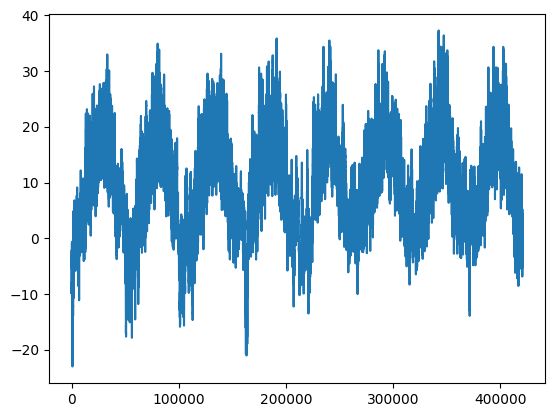

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

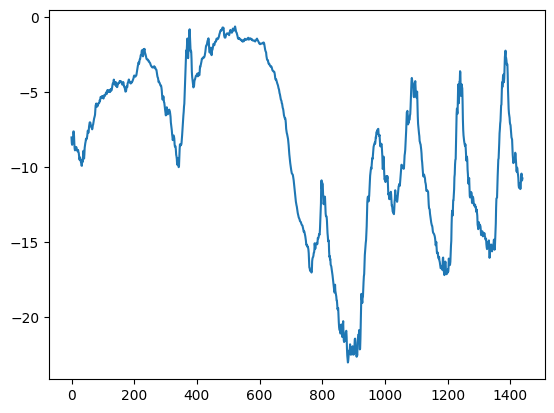

In [ ]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### Building a baseline "model"

In this case we will try to predict the temperature by simply assuming that the temperature 24 hours from now will be equal to the temperature right now.

We shall use the mean absolute error (MAE) as a metric of performance and consider this (rather silly) "model" as our baseline.


**Computing the common-sense baseline MAE**

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Building our *real* first model

This is essentially the "simple LSTM-based model" from Listing 10.12 in the textbook.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 51s 54ms/step - loss: 43.2915 - mae: 4.7757 - val_loss: 12.7227 - val_mae: 2.6986
Epoch 2/10
819/819 [==============================] - 44s 54ms/step - loss: 10.8452 - mae: 2.5584 - val_loss: 9.8237 - val_mae: 2.4398
Epoch 3/10
819/819 [==============================] - 43s 52ms/step - loss: 9.8002 - mae: 2.4483 - val_loss: 9.8030 - val_mae: 2.4349
Epoch 4/10
819/819 [==============================] - 45s 55ms/step - loss: 9.5168 - mae: 2.4080 - val_loss: 9.6064 - val_mae: 2.4008
Epoch 5/10
819/819 [==============================] - 43s 52ms/step - loss: 9.2230 - mae: 2.3684 - val_loss: 9.5865 - val_mae: 2.3980
Epoch 6/10
819/819 [==============================] - 44s 53ms/step - loss: 8.9690 - mae: 2.3355 - val_loss: 9.5996 - val_mae: 2.3962
Epoch 7/10
819/819 [==============================] - 43s 52ms/step - loss: 8.8067 - mae: 2.3121 - val_loss: 9.4869 - val_mae: 2.3906
Epoch 8/10
819/819 [==============================] - 43s 5

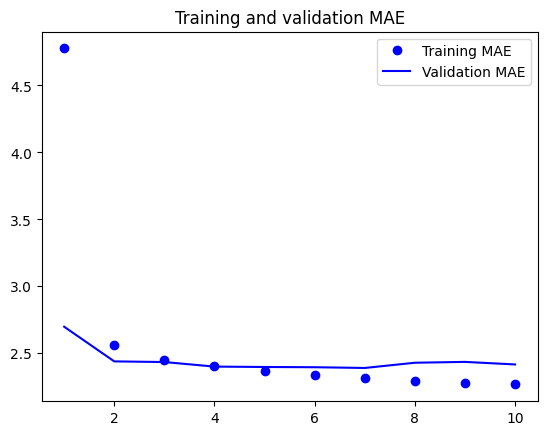

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Summary table
(Example, manually generated)

You can use the table below to show a summary of the experimental results. **Replace the Test MAE values and other contents with your own!**

| Method | Test MAE | Remarks |
| --- | --- | --- |
| Baseline | 2.62 | Silly model: "tomorrow will be like today" |
| Real first model (LSTM) | 2.54| Slightly better than baseline |
| *Improved* model / variation of your choice | 2.12| Best overall, still shows signs of overfitting |


Epoch 1/10
819/819 [==============================] - 46s 53ms/step - loss: 7.6275 - mae: 7.6275 - val_loss: 6.7359 - val_mae: 6.7359
Epoch 2/10
819/819 [==============================] - 42s 51ms/step - loss: 7.2274 - mae: 7.2274 - val_loss: 6.6971 - val_mae: 6.6971
Epoch 3/10
819/819 [==============================] - 42s 51ms/step - loss: 7.1871 - mae: 7.1872 - val_loss: 6.7003 - val_mae: 6.7003
Epoch 4/10
819/819 [==============================] - 50s 61ms/step - loss: 7.1678 - mae: 7.1678 - val_loss: 6.6834 - val_mae: 6.6834
Epoch 5/10
819/819 [==============================] - 50s 60ms/step - loss: 7.1561 - mae: 7.1561 - val_loss: 6.6879 - val_mae: 6.6879
Epoch 6/10
819/819 [==============================] - 42s 51ms/step - loss: 7.1468 - mae: 7.1468 - val_loss: 6.6859 - val_mae: 6.6859
Epoch 7/10
819/819 [==============================] - 42s 51ms/step - loss: 7.1388 - mae: 7.1388 - val_loss: 6.6765 - val_mae: 6.6765
Epoch 8/10
819/819 [==============================] - 43s 52ms

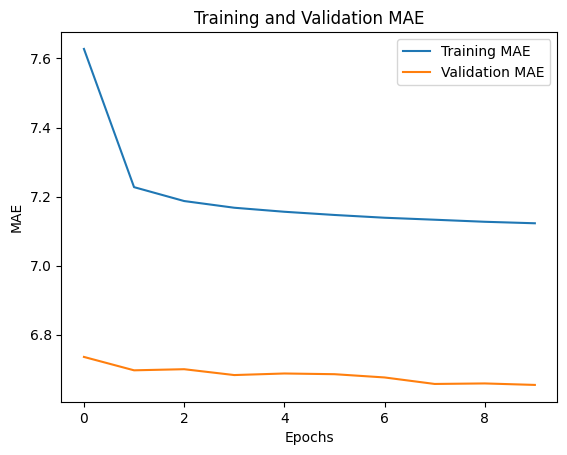

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_absolute_error

num_features = raw_data.shape[-1]
sequence_length = 10
inputs = Input(shape=(sequence_length, num_features))

x = Dense(32, activation='relu')(inputs)
x = Dropout(0.3)(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)
model = Model(inputs, outputs)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="mae", metrics=["mae"])

callbacks = [ModelCheckpoint("best_model.h5", save_best_only=True), EarlyStopping(patience=5)]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

test_mae = model.evaluate(test_dataset)[1]

print("Test MAE:", test_mae)

import matplotlib.pyplot as plt

plt.plot(history.history["mae"])
plt.plot(history.history["val_mae"])
plt.title("Training and Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend(["Training MAE", "Validation MAE"])
plt.show()


## Part 2: Sentiment analysis using LSTMs

In Part 2 we will revisit the IMDB movie review classification task from an earlier assignment, this time using more sophisticated approaches and architectures.

Please refer to Chapter 11 of [our textbook](https://learning.oreilly.com/library/view/deep-learning-with/9781617296864) for background information on NLP and approaches for text representation in deep learning architectures.

The code (and much of the text) below is essentially from https://www.tensorflow.org/text/tutorials/text_classification_rnn  


Useful sources and references for Part 2:

- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part01_introduction.ipynb
- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part02_sequence-models.ipynb


### Imports + auxiliary function

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Going into this movie, I had heard good things about it. Coming out of it, I wasn't really amazed nor disappointed. Simon Pegg plays a rather childish character much like his other movies. There were a couple of laughs here and there-- nothing too funny. Probably my favorite parts of the movie is when he dances in the club scene. I totally gotta try that out next time I find myself in a club. A couple of stars here and there including: Megan Fox, Kirsten Dunst, that chick from X-Files, and Jeff Bridges. I found it quite amusing to see a cameo appearance of Thandie Newton in a scene. She of course being in a previous movie with Simon Pegg, Run Fatboy Run. I see it as a toss up, you'll either enjoy it to an extent or find it a little dull. I might add, Kirsten Dunst is adorable in this movie. :3"
 b'This program is really overrated. A detective like Danny Pino\'s hot-headed character would have been transferred to the "rubber gun squad" years ago. The whole squad is made up of

### Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 29,   5,   2, ...,   0,   0,   0],
       [452, 590,  49, ...,   0,   0,   0],
       [208,  11,  56, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'One of the best if not the best rock\'n\'roll movies ever. And it\'s not just mindless fun. There really were a lot of clever jokes in it. Of course I love the Ramones. But with all the "anarchy" and the "I hate high school" themes, the film doesn\'t at all take itself too seriously,which is what\'s great about it.<br /><br />I first saw the movie in the Spring of 1980, and I saw it again recently. Since I went to high school in the late 1970\'s, it made me kind of nostalgic. <br /><br />Like I said, this film doesn\'t take itself that seriously and isn\'t pretentious like so much other teen fare of the seventies, eighties, and nineties. And to speak of, it\'s not really dirty or disgusting either. Only PG rated. That\'s rare for a movie in this category. A great cult classic and a truly incredible time capsule.'
Round-trip:  one of the best if not the best [UNK] movies ever and its not just [UNK] fun there really were a lot of [UNK] jokes in it of course i love the [UNK] 

### Create the first model

Please refer to https://www.tensorflow.org/text/tutorials/text_classification_rnn for detailed explanation + diagram.

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 4s 4s/step
[0.00353277]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 72ms/step
[0.00353277]


Compile the Keras model to configure the training process:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### Train the model

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 69s 149ms/step - loss: 0.6535 - accuracy: 0.5577 - val_loss: 0.4929 - val_accuracy: 0.7828
Epoch 2/10
391/391 [==============================] - 34s 86ms/step - loss: 0.4175 - accuracy: 0.8124 - val_loss: 0.3830 - val_accuracy: 0.8359
Epoch 3/10
391/391 [==============================] - 31s 77ms/step - loss: 0.3462 - accuracy: 0.8490 - val_loss: 0.3447 - val_accuracy: 0.8562
Epoch 4/10
391/391 [==============================] - 32s 81ms/step - loss: 0.3221 - accuracy: 0.8613 - val_loss: 0.3394 - val_accuracy: 0.8422
Epoch 5/10
391/391 [==============================] - 32s 82ms/step - loss: 0.3131 - accuracy: 0.8664 - val_loss: 0.3234 - val_accuracy: 0.8656
Epoch 6/10
391/391 [==============================] - 30s 77ms/step - loss: 0.3062 - accuracy: 0.8694 - val_loss: 0.3341 - val_accuracy: 0.8536
Epoch 7/10
391/391 [==============================] - 31s 78ms/step - loss: 0.3017 - accuracy: 0.8720 - val_loss: 0.3205 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 16s 41ms/step - loss: 0.3178 - accuracy: 0.8542
Test Loss: 0.3177717626094818
Test Accuracy: 0.8542400002479553


(0.0, 0.6714437931776047)

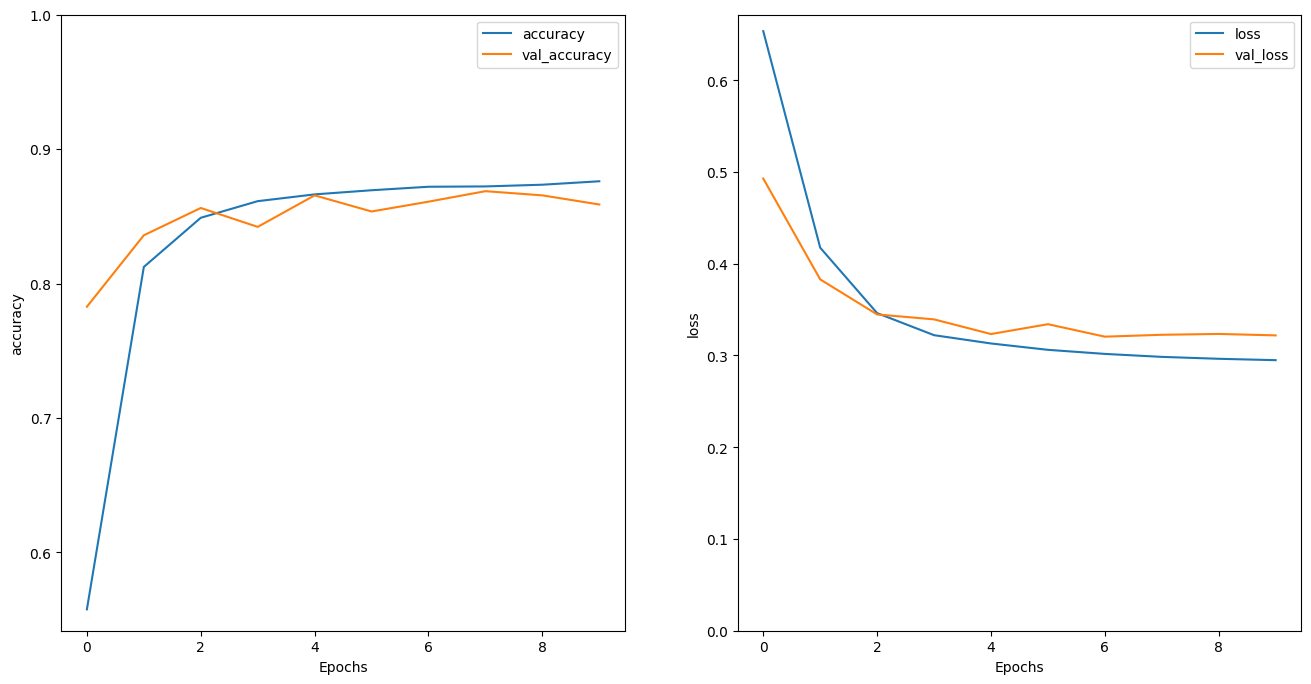

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 0s 51ms/step


### Second model: stacking two LSTM layers

Please refer to https://www.tensorflow.org/text/tutorials/text_classification_rnn for additional explanation + diagram.

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 100s 197ms/step - loss: 0.6421 - accuracy: 0.5683 - val_loss: 0.4447 - val_accuracy: 0.8047
Epoch 2/10
391/391 [==============================] - 58s 149ms/step - loss: 0.3899 - accuracy: 0.8296 - val_loss: 0.3552 - val_accuracy: 0.8443
Epoch 3/10
391/391 [==============================] - 59s 149ms/step - loss: 0.3351 - accuracy: 0.8565 - val_loss: 0.3349 - val_accuracy: 0.8417
Epoch 4/10
391/391 [==============================] - 59s 151ms/step - loss: 0.3235 - accuracy: 0.8639 - val_loss: 0.3243 - val_accuracy: 0.8531
Epoch 5/10
391/391 [==============================] - 58s 147ms/step - loss: 0.3129 - accuracy: 0.8659 - val_loss: 0.3209 - val_accuracy: 0.8583
Epoch 6/10
391/391 [==============================] - 57s 146ms/step - loss: 0.3070 - accuracy: 0.8685 - val_loss: 0.3233 - val_accuracy: 0.8500
Epoch 7/10
391/391 [==============================] - 58s 148ms/step - loss: 0.3039 - accuracy: 0.8691 - val_loss: 0.3205 - val_a

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 26s 68ms/step - loss: 0.3168 - accuracy: 0.8508
Test Loss: 0.31681591272354126
Test Accuracy: 0.8507999777793884


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.8912623]]


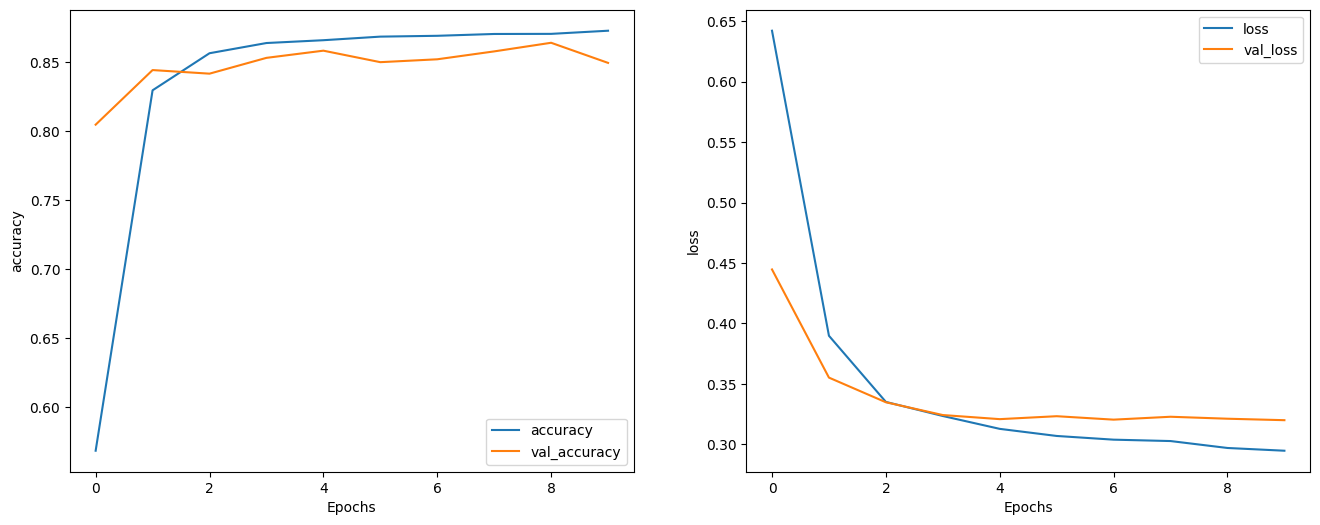

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

### TODO 2: Improve the solution for IMDB sentiment analysis
Write code to produce another solution to the movie review problem that outperforms the two solutions provided above, i.e, has a higher test accuracy.

You can use a (combination of) different architecture, dropout and/or other regularization strategies, hyperparameter optimizations, masking, pretrained embeddings, or any other acceptable "trick" in the deep learning world.

### Summary table
(Example, manually generated)

You can use the table below to show a summary of the experimental results. **Replace the Test Accuracy values and other contents with your own!**

| Method | Test Accuracy | Remarks |
| --- | --- | --- |
| First model | 0.856 | Baseline |
| Second model (LSTM) | 0.851 | Slightly worse than baseline |
| *Improved* model / variation of your choice | 0.915 | Best overall |


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)


maxlen = 200
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)


model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=maxlen))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

loss, accuracy = model.evaluate(x_test, y_test)

print(f'Test accuracy: {accuracy}')


17464789/17464789 [==============================] - 0s 0us/step
Epoch 1/10
625/625 [==============================] - 222s 351ms/step - loss: 0.6159 - accuracy: 0.6473 - val_loss: 0.5125 - val_accuracy: 0.7724
Epoch 2/10
625/625 [==============================] - 217s 347ms/step - loss: 0.5360 - accuracy: 0.7376 - val_loss: 0.6520 - val_accuracy: 0.5704
Epoch 3/10
625/625 [==============================] - 225s 360ms/step - loss: 0.5140 - accuracy: 0.7064 - val_loss: 0.3883 - val_accuracy: 0.8426
Epoch 4/10
625/625 [==============================] - 214s 343ms/step - loss: 0.2593 - accuracy: 0.8939 - val_loss: 0.3065 - val_accuracy: 0.8732
Epoch 5/10
625/625 [==============================] - 217s 346ms/step - loss: 0.1658 - accuracy: 0.9402 - val_loss: 0.3538 - val_accuracy: 0.8820
Epoch 6/10
625/625 [==============================] - 217s 347ms/step - loss: 0.1157 - accuracy: 0.9607 - val_loss: 0.3969 - val_accuracy: 0.8744
Epoch 7/10
625/625 [==============================] - 216s 

## Part 3: NLP using Transformers

In Part 3 we will look at the Transformer architecture and how it can be used in a specific NLP task, machine translation (from English to Spanish).

Please refer to Chapter 11 of [our textbook](https://learning.oreilly.com/library/view/deep-learning-with/9781617296864) for additional information.


Useful sources and references for Part 3:

- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part03_transformer.ipynb
- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part04_sequence-to-sequence-learning.ipynb


### Setup

In [ ]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip

--2023-04-15 03:04:03--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.52M  --.-KB/s    in 0.01s   

2023-04-15 03:04:03 (250 MB/s) - ‘spa-eng.zip’ saved [2638744/2638744]



In [ ]:
text_file = "spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    english, spanish = line.split("\t")
    spanish = "[start] " + spanish + " [end]"
    text_pairs.append((english, spanish))

In [ ]:
import random
print(random.choice(text_pairs))

("We're the only people here.", '[start] Somos las únicas personas aquí. [end]')


In [ ]:
import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

**Vectorizing the English and Spanish text pairs**

In [ ]:
import tensorflow as tf
import string
import re

from tensorflow import keras
from tensorflow.keras import layers

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000
sequence_length = 20

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

**Preparing datasets for the translation task**

In [ ]:
batch_size = 64

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({
        "english": eng,
        "spanish": spa[:, :-1],
    }, spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['spanish'].shape: (64, 20)
targets.shape: (64, 20)


### The Transformer encoder

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

### The Transformer decoder

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

### Putting it all together: A Transformer for machine translation

**PositionalEmbedding layer**

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

**End-to-end Transformer**

In [ ]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

**Training the sequence-to-sequence Transformer**

In [ ]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
transformer.fit(train_ds, epochs=10, validation_data=val_ds)

**Translating new sentences with our Transformer model**

In [ ]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
I wish I knew where he was!
[start] me gusta que me lo que él [end]
-
He didn't really go to the church.
[start] Él no me dijo que la verdad [end]
-
He wants to be more independent.
[start] Él quiere ir a la verdad [end]
-
Where are my books?
[start] dónde estás mi padre [end]
-
We had a wonderful holiday in Sweden.
[start] tenemos un perro [end]
-
I've dealt with this store for years.
[start] he estado nada [end]
-
Stay positive.
[start] eso es [end]
-
Tom can walk only if he has his cane.
[start] tom puede que tom si se ha estado [end]
-
Tom can walk to his office in thirty minutes or less.
[start] tom se dijo que su vida en su vida [end]
-
She didn't run fast enough to catch the bus.
[start] ella no se ha estado bien [end]
-
Tom sang softly.
[start] tom se [UNK] [end]
-
Have you known her since 1990?
[start] has estado [UNK] su vida [end]
-
My father does not go to Tokyo today.
[start] mi padre no se le gusta la verdad [end]
-
You must meet with her.
[start] estás [UNK] [end]
-
Th

## Conclusions
Part 1: Temperature forecasting using RNNs
Working on a project to forecast temperature using RNNs taught me the value of feature engineering and data pretreatment. Since there are several factors in the data, it is crucial to identify the ones that are essential for temperature forecasting and to normalize the data so that each variable contributes equally to the predictions made by the model. The creation of additional variables, such as lagged variables or rolling averages, that might be helpful for temperature forecasting is another capability of feature engineering.

The significance of hyperparameter adjustment is a further lesson. The performance of an RNN may be greatly influenced by a variety of hyperparameters, including the number of layers, the number of units in each layer, and the learning rate. The most effective hyperparameters for the job may be found by experimenting with various settings and assessing the model's performance on a validation set.

Finally, the trade-off between model complexity and interpretability must be taken into account. Given the complexity of RNNs, it might be difficult to comprehend how the model predicts outcomes. To make sure that the model's predictions are helpful and intelligible for the end users, it is crucial to strike a balance between the complexity of the model and the interpretability of the findings.


Part 2: Sentiment analysis using LSTMs
Working with Long Short-Term Memory (LSTM) networks on a sentiment analysis job taught us the value of handling unbalanced input. The IMDB movie review dataset may include a disproportionate number of favorable or negative evaluations, creating an unbalanced dataset. Datasets that are unbalanced can provide biased models that underperform for the minority class.

One solution to this problem is to utilize methods like oversampling or undersampling to balance the dataset. To give the minority class additional weight during training, another strategy is to utilize weighted loss functions or class weights. To make sure the model is successful in predicting both positive and negative ratings, it's critical to assess the model's performance on both the majority and minority classes.

The significance of employing pre-trained embeddings is a further lesson gained. Pre-trained embeddings, like GloVe or Word2Vec, are valuable for natural language processing applications like sentiment analysis since they can capture the semantic meaning of words and were trained on huge corpora of text. Compared to training, using pre-trained embeddings can save time and enhance model performance.

Part 3: NLP using Transformers
Transformer architecture on a Natural Language Processing (NLP) assignment taught us the value of attention methods. Transformers are able to better grasp long-range dependencies and perform better on NLP tasks like machine translation because they employ self-attention to balance the significance of various input sequence components when formulating predictions.

The value of tokenization and pre-processing is another thing that was discovered. Tokenization is the process of dividing a text into smaller pieces, such words or subwords, so that they may be supplied as input into the Transformer. Pre-processing involves operations like punctuation removal, text conversion to lowercase, and managing special characters, which can enhance the Transformer's performance.